In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import random
import os

In [2]:
train_input_dir = "data/train/huawei_raw"
train_target_dir = "data/train/canon"
test_input_dir = "data/test/huawei_raw"
test_target_dir = "data/test/canon"
img_size = (224, 224)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".jpg")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".jpg")
    ]
)


print("Number of samples:", len(input_img_paths))
print("Number test of samples:", len(test_input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 46839
Number test of samples: 1204
data/train/huawei_raw/0.png | data/train/canon/0.jpg
data/train/huawei_raw/1.png | data/train/canon/1.jpg
data/train/huawei_raw/10.png | data/train/canon/10.jpg
data/train/huawei_raw/100.png | data/train/canon/100.jpg
data/train/huawei_raw/1000.png | data/train/canon/1000.jpg
data/train/huawei_raw/10000.png | data/train/canon/10000.jpg
data/train/huawei_raw/10001.png | data/train/canon/10001.jpg
data/train/huawei_raw/10002.png | data/train/canon/10002.jpg
data/train/huawei_raw/10003.png | data/train/canon/10003.jpg
data/train/huawei_raw/10004.png | data/train/canon/10004.jpg


In [3]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

In [4]:
from isp.dataset.loader import HuaveiLoader

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)
test_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, test_input_img_paths, test_target_img_paths
)

In [5]:
x, y = train_gen.__getitem__(0)

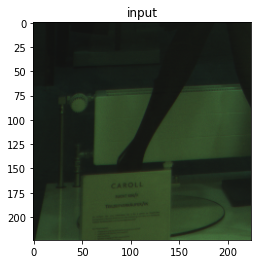

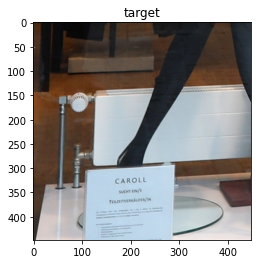

In [6]:
plt_display(x[0][:,:,0:3], 'input')
plt_display(y[0], 'target')

In [7]:
from isp.models.unet import get_model

model = get_model(input_shape=(224, 224, 4))
model.summary()

2022-03-18 14:38:01.523028: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-18 14:38:01.523220: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-18 14:38:01.523935: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
from isp.utils.losses import mssim, color, exp_fusion, vgg_loss

losses = {
    'mae_out': 'mae',
    'mssim_out': mssim,
    'color_out': color,
    'exp_out': exp_fusion,
    'vgg_out': vgg_loss,
}

model.compile(optimizer="adam", loss=losses)

In [9]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
]


model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

2022-03-18 14:38:27.280576: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-18 14:38:27.299035: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


   2/2864 [..............................] - ETA: 20:37:59 - loss: 2.3954 - conv2d_25_loss: 0.2665 - conv2d_25_1_loss: 0.4558 - conv2d_25_2_loss: 0.0093 - conv2d_25_3_loss: 3.1551e-04 - conv2d_25_4_loss: 1.6636

In [1]:
x, y = train_gen.__getitem__(0)
preds = model.predict(x)
preds[0].shape

NameError: name 'train_gen' is not defined